# 8.3.2 배치 정규화와 드롭아웃

## 1. 배치정규화

### 라이브러리 호출

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 데이터셋 내려받기

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='/', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 15086973.90it/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268408.61it/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5030940.86it/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17315378.50it/s]


Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



### 데이터셋을 메모리로 가져오기 (이미지 출력을 위한 용도)

In [ ]:
batch_size = 4 # 한 번에 4개씩 쪼개서 가져온다
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

### 데이터셋 분리

In [ ]:
dataiter = iter(trainloader) # trainloader로부터 데이터를 가져와서 반복할 수 있는 iterator를 생성
images, labels = next(dataiter) # 다음에 사용할 데이터 배치를 가져옴

print(images.shape) # 이미지 배치의 형태 출력 (배치, 채널, 높이, 너비)
print(images[0].shape) # (채널, 높이, 너비)
print(labels[0].item()) # 첫 번째 이미지의 레이블 출력

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
8


### 이미지 데이터를 출력하기 위한 전처리

In [ ]:
def imshow(img, title):
    plt.figure(figsize = (batch_size * 4, 4)) # figure 사이즈 지정
    plt.axis('off') # 시각화 시 축 표시 x
    plt.imshow(np.transpose(img, (1,2,0))) # 시각화 시에는 데이터 형태를 [batch_size, height, width, channel]로 바꿔줘야 함
                                           # 따라서 시각화 직전에 바꾸고 시각화(imshow, image show)
    plt.title(title) # 제목
    plt.show() # 시각화 결과 출력(실제 화면에 보이도록)

### 이미지 데이터 출력 함수

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader)) # 이미지의 크기는 (4, 1, 28, 28)이 된다 (배치, 채널, 높이, 너비)
    img = torchvision.utils.make_grid(images) # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력, 여러 이미지를 하나의 이미지로 합쳐서 보여줌
    imshow(img, title=[str(x.item()) for x in labels]) # imshow 함수를 사용해 데이터의 형태가 (4, 28, 28 1)(배치, 높이, 너비, 채널)로 변경됨
    return images, labels

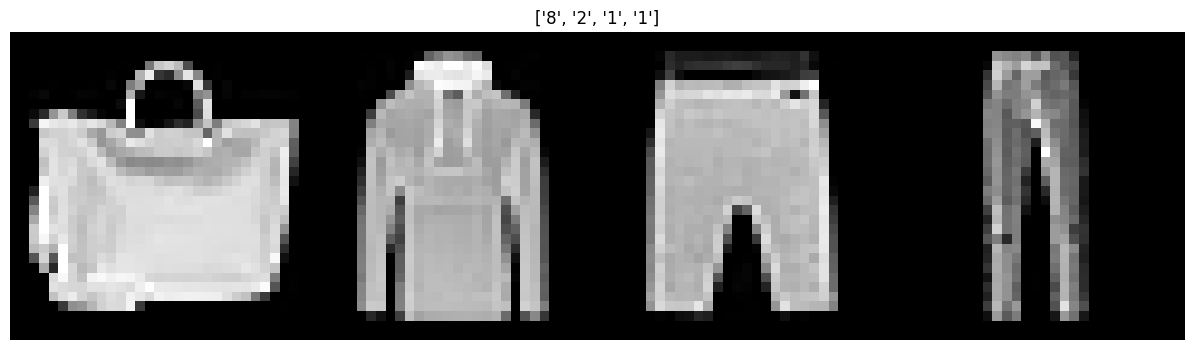

In [ ]:
images, labels = show_batch_images(trainloader)
# 4개의 이미지가 출력되는 이유는 한 번의 배치에서 4개의 이미지만 가져오도록 했기 때문이다

### 배치 정규화가 적용되지 않은 네트워크

In [ ]:
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # FashionMNIST의 클래스는 총 10개
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # nn.Sequential에서 정의한 계층 호출
        return x

### 배치 정규화가 포함된 네트워크

In [ ]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48), # 배치 정규화가 적용되는 부분
                                # 사용되는 파라미터는 특성 개수로 이전 계층의 출력 채널
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 배치 정규화가 적용되지 않은 모델 선언

In [ ]:
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


### 배치 정규화가 적용된 모델 선언

In [ ]:
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


### 데이터셋 메모리로 불러오기 (학습을 위한 용도)

In [ ]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

### 옵티마이저와 손실 함수 지정

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

### 모델 학습

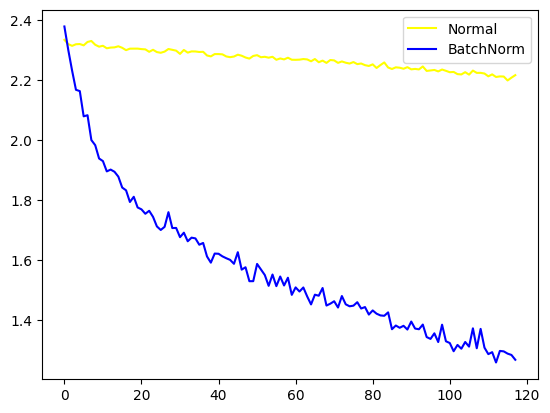

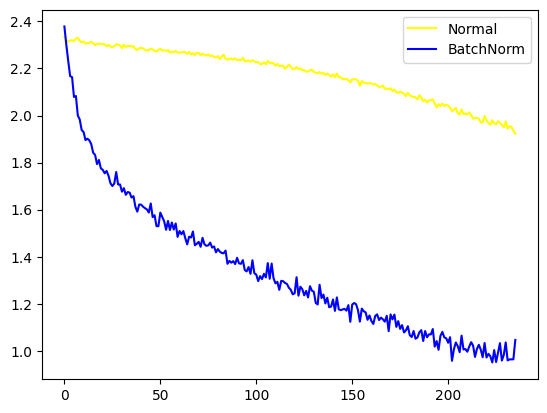

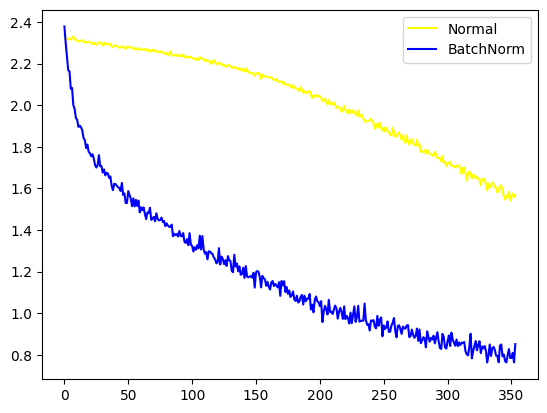

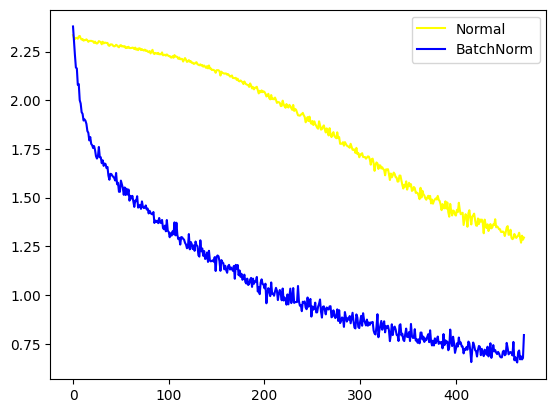

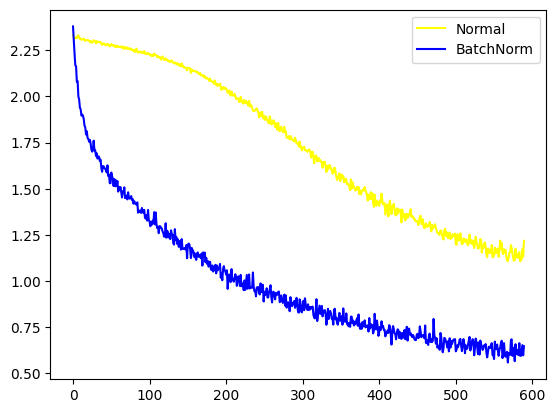

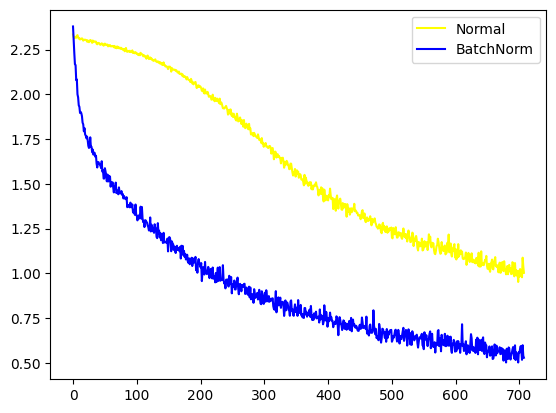

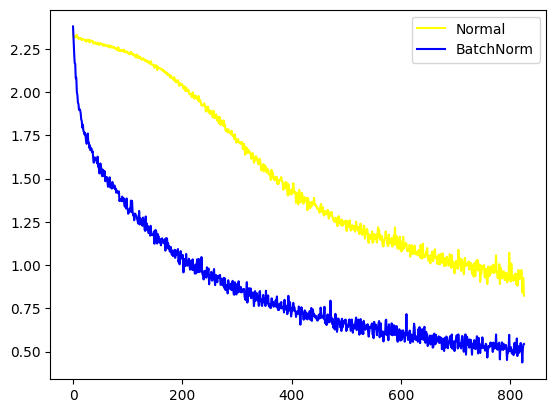

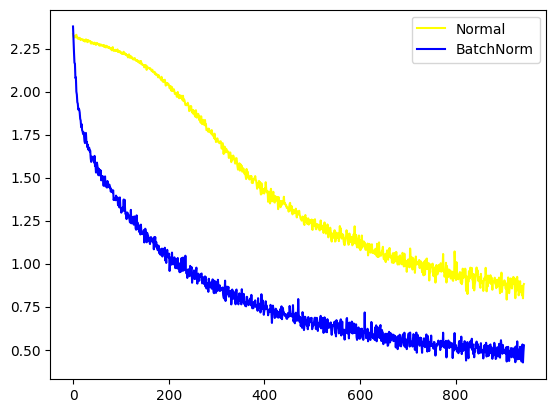

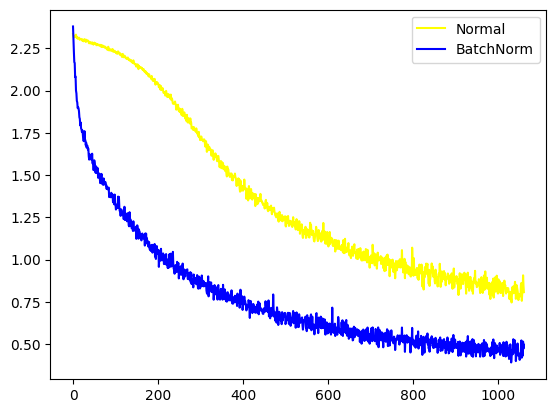

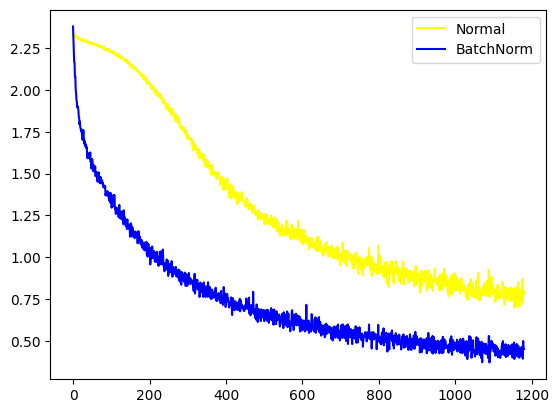

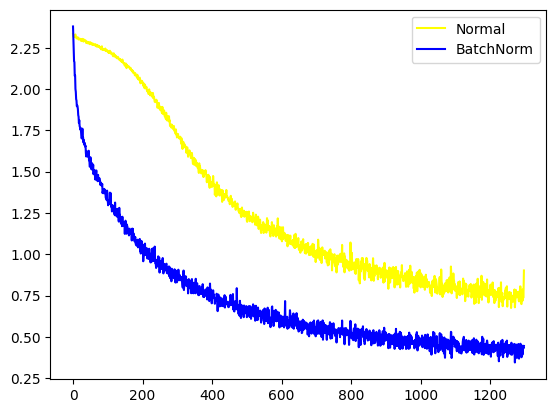

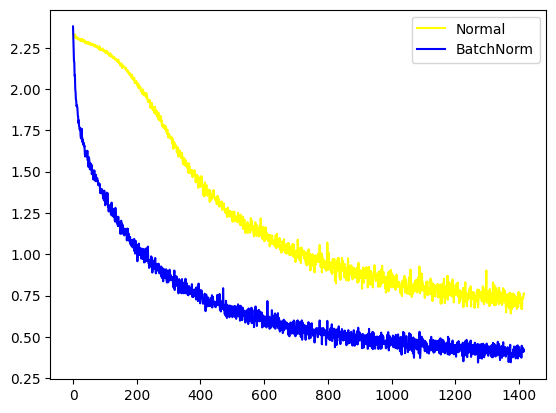

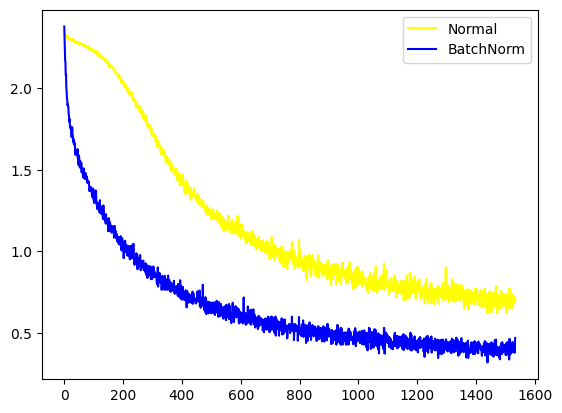

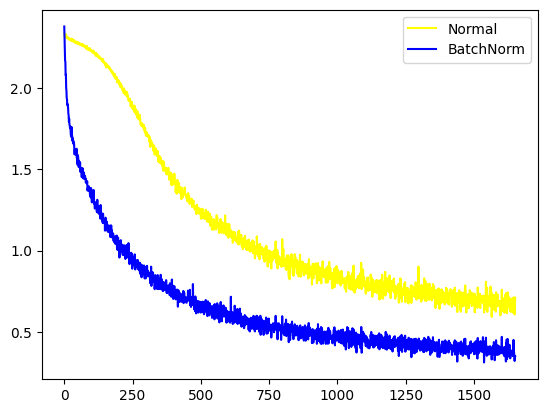

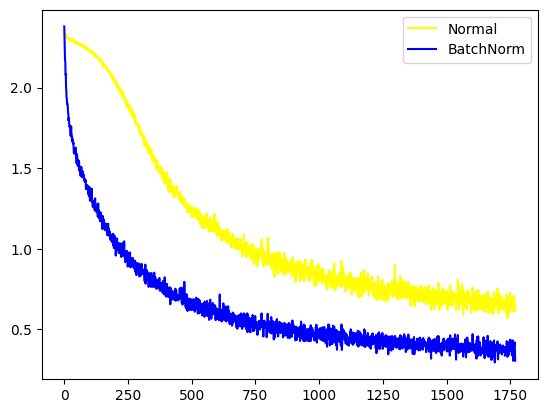

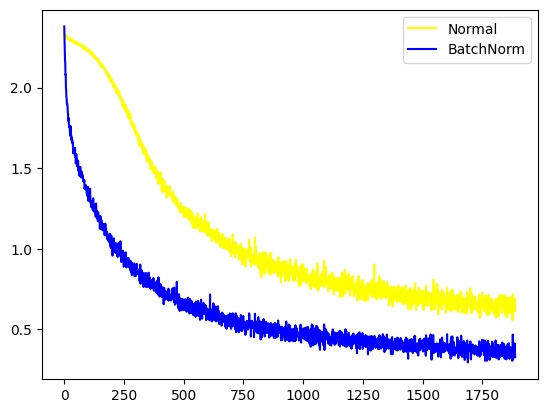

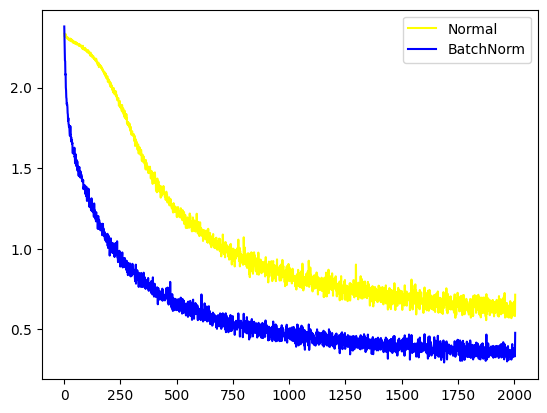

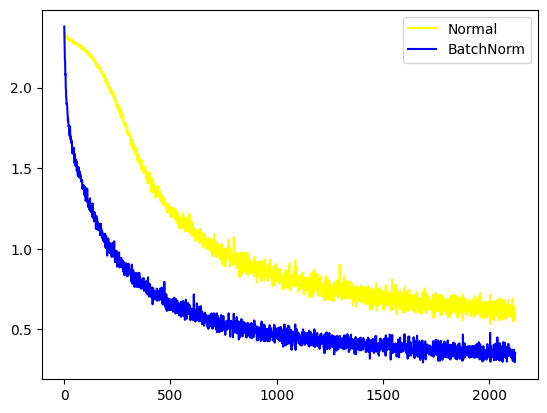

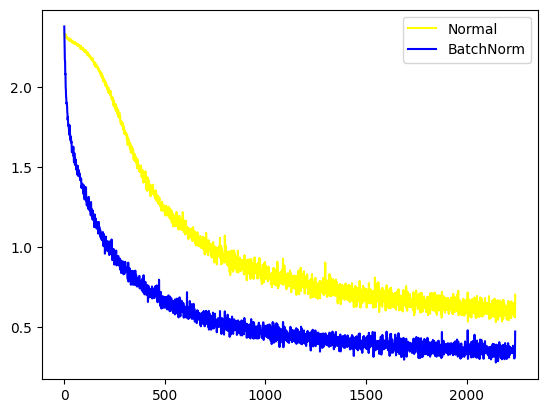

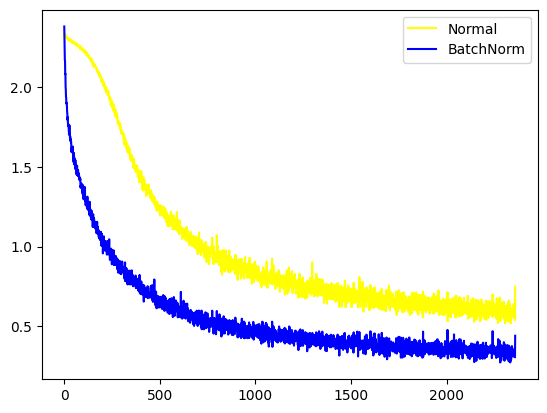

In [ ]:
loss_arr = []  # 배치 정규화가 적용되지 않은 모델의 손실을 저장할 리스트
loss_bn_arr = []  # 배치 정규화가 적용된 모델의 손실을 저장할 리스트
max_epochs = 20  # 최대 에포크 수

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0): # 0 : 인덱스 시작값
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()  # 배치 정규화가 적용되지 않은 모델의 학습
        outputs = model(inputs).to(device)  # 모델에 입력 데이터를 전달하여 출력을 계산합니다.
        loss = loss_fn(outputs, labels)  # 손실을 계산합니다.
        loss.backward()  # 손실에 대한 그래디언트를 계산합니다.
        opt.step()  # 모델의 파라미터를 업데이트합니다.

        opt_bn.zero_grad()  # 배치 정규화가 적용된 모델의 학습
        outputs_bn = model_bn(inputs)  # 배치 정규화가 적용된 모델에 입력 데이터를 전달하여 출력을 계산합니다.
        loss_bn = loss_fn(outputs_bn, labels)  # 손실을 계산합니다.
        loss_bn.backward()  # 손실에 대한 그래디언트를 계산합니다.
        opt_bn.step()  # 모델의 파라미터를 업데이트합니다.

        loss_arr.append(loss.item())  # 배치 정규화가 적용되지 않은 모델의 손실을 리스트에 추가합니다.
        loss_bn_arr.append(loss_bn.item())  # 배치 정규화가 적용된 모델의 손실을 리스트에 추가합니다.

    # 손실 그래프를 그립니다.
    plt.plot(loss_arr, 'yellow', label='Normal')  # 배치 정규화가 적용되지 않은 모델의 손실 그래프를 그립니다.
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')  # 배치 정규화가 적용된 모델의 손실 그래프를 그립니다.
    plt.legend()  # 범례를 표시합니다.
    plt.show()  # 그래프를 화면에 출력합니다.


## 2. 드롭아웃

### 데이터셋의 분포를 출력하기 위한 전처리

In [ ]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1) # torch.linspace : -1~1의 범위에서 N개의 균등한 값을 갖는 텐서를 생성
                                                       # torch.unsqueeze : 텐서의 첫 번째 자리에 차원을 증가시키겠다 -> 열벡터가 됨 (N, 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1)) # 훈련 데이터셋 값의 범위가 정규분포를 갖도록 조정
                                                                              # torch.zeros : 0 값을 갖는 Nx1 텐서 생성
                                                                              # torch.ones : 1 값을 갖는 Nx1 텐서 생성
                                                                              # torch.normal : 정규분포로부터 무작위 표본 추출
#x_train, y_train= x_train.to(device), y_train.to(device)
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
#x_test, y_test = x_test.to(device), y_test.to(device)

### 데이터 분포를 그래프로 출력

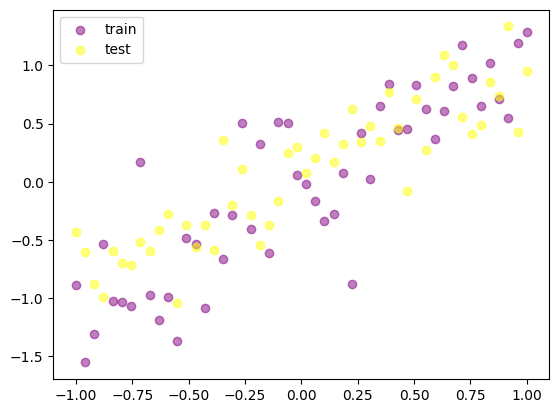

In [ ]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

### 드롭아웃을 위한 모델 생성

In [ ]:
N_h = 100 # 은닉층의 뉴런 개수

# 드롭아웃이 적용되지 않은 모델
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),  # 입력층(input layer)에서 은닉층(hidden layer)으로의 선형 변환
    torch.nn.ReLU(),           # 은닉층의 활성화 함수(ReLU)
    torch.nn.Linear(N_h, N_h), # 첫 번째 은닉층에서 두 번째 은닉층으로의 선형 변환
    torch.nn.ReLU(),           # 두 번째 은닉층의 활성화 함수(ReLU)
    torch.nn.Linear(N_h, 1),   # 두 번째 은닉층에서 출력층(output layer)으로의 선형 변환
)

# 드롭아웃 적용
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),  # 입력층에서 은닉층으로의 선형 변환
    torch.nn.Dropout(0.2),    # 드롭아웃 층(dropout layer) - 20%의 뉴런을 무작위로 선택하여 사용하지 않음
    torch.nn.ReLU(),          # 은닉층의 활성화 함수(ReLU)
    torch.nn.Linear(N_h, N_h),# 첫 번째 은닉층에서 두 번째 은닉층으로의 선형 변환
    torch.nn.Dropout(0.2),    # 드롭아웃 층(dropout layer) - 20%의 뉴런을 무작위로 선택하여 사용하지 않음
    torch.nn.ReLU(),          # 두 번째 은닉층의 활성화 함수(ReLU)
    torch.nn.Linear(N_h, 1),  # 두 번째 은닉층에서 출력층으로의 선형 변환
)

### 옵티마이저와 손실 함수 지정

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

### 모델 학습

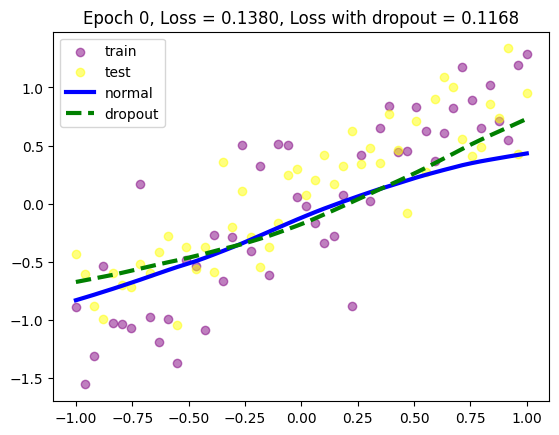

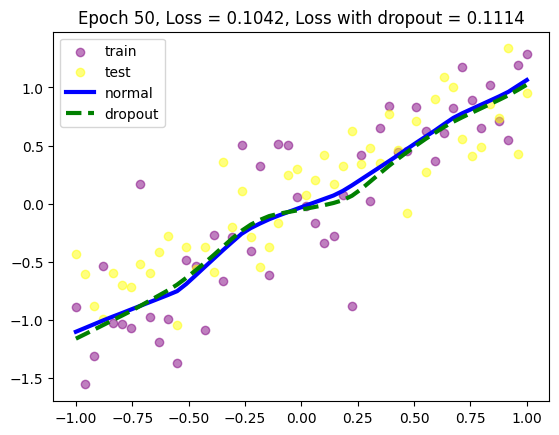

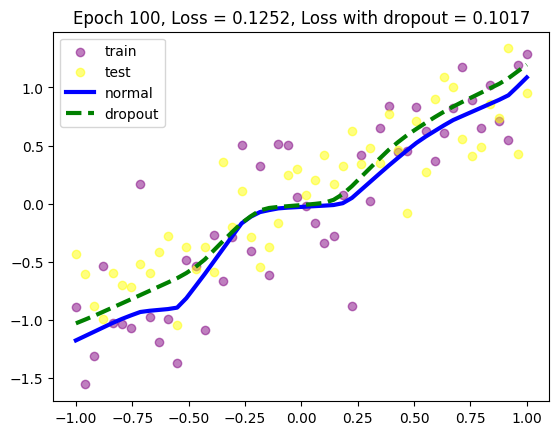

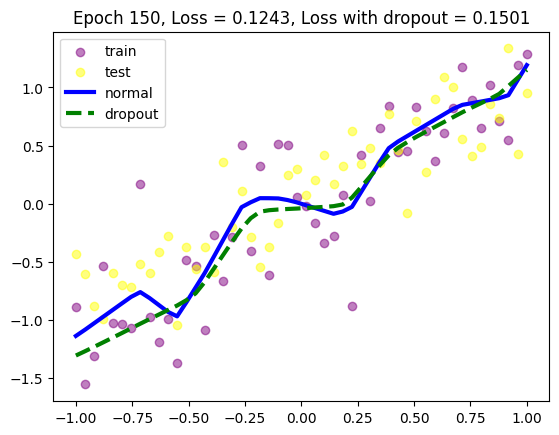

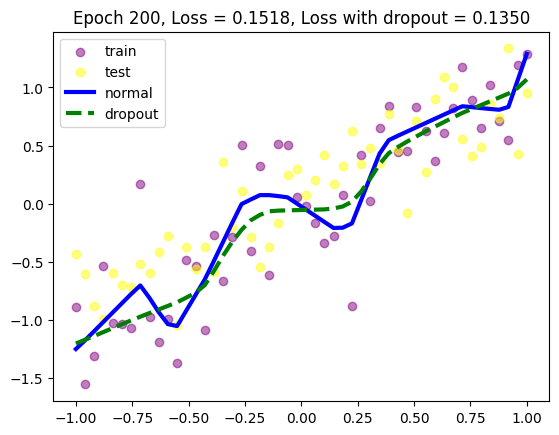

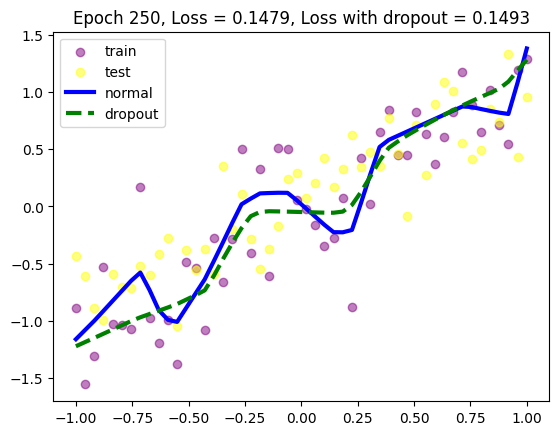

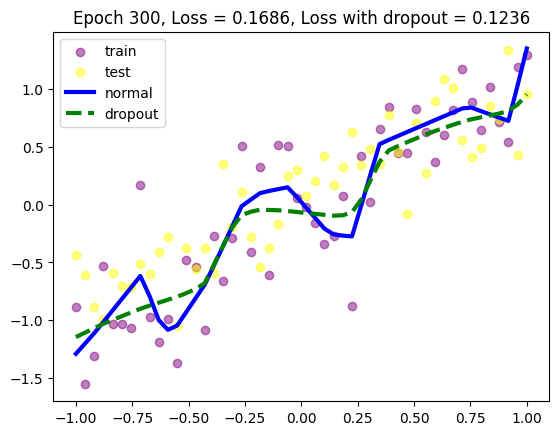

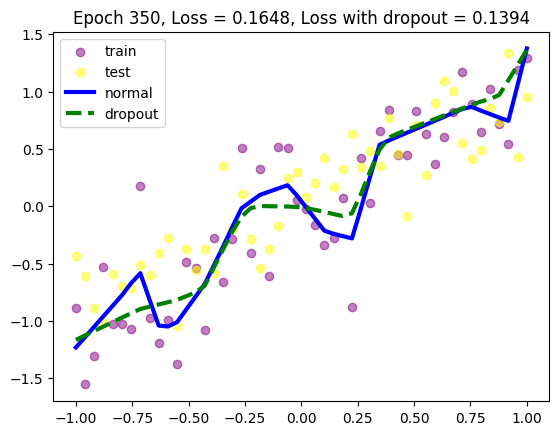

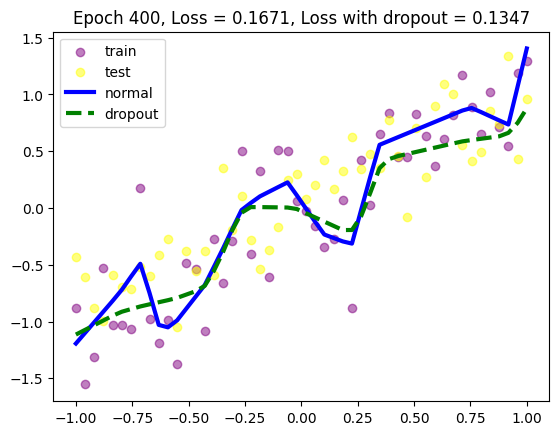

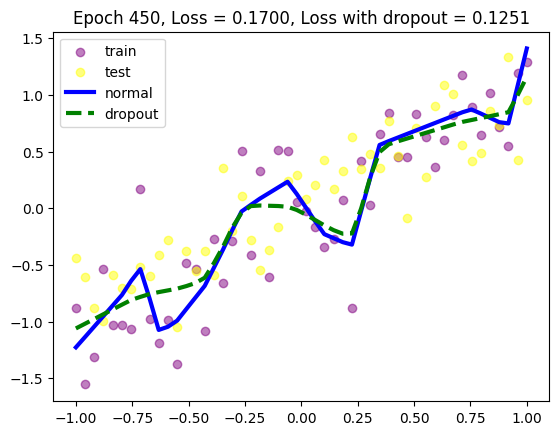

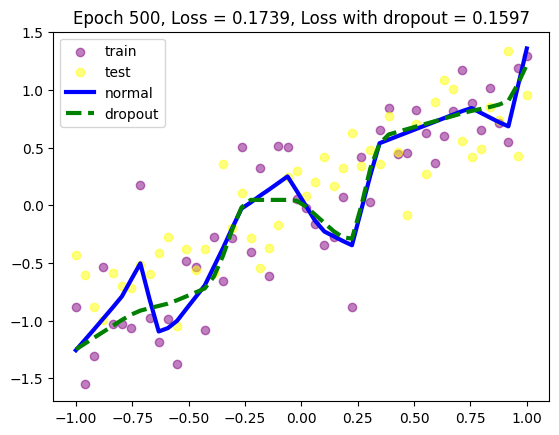

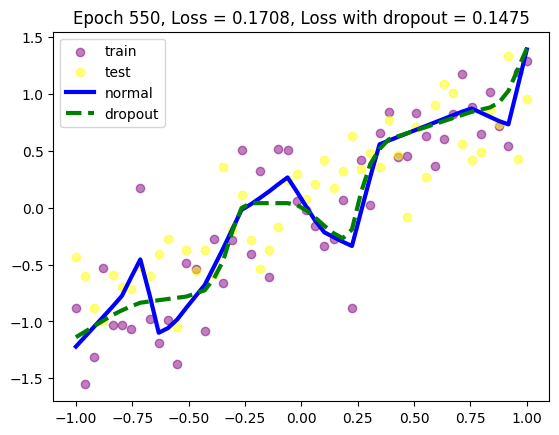

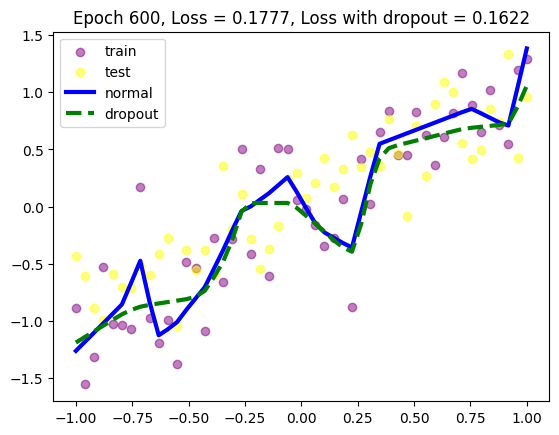

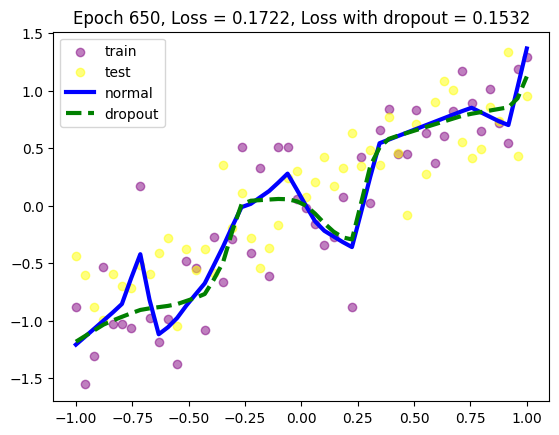

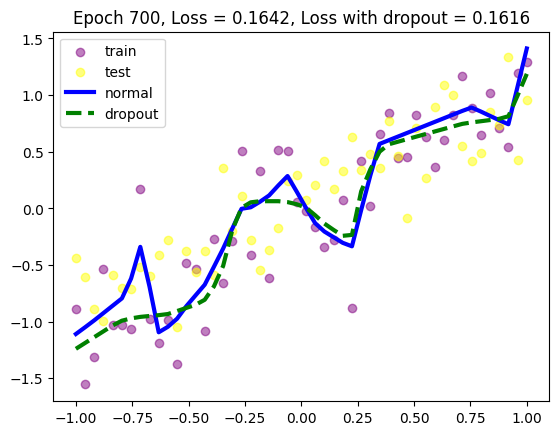

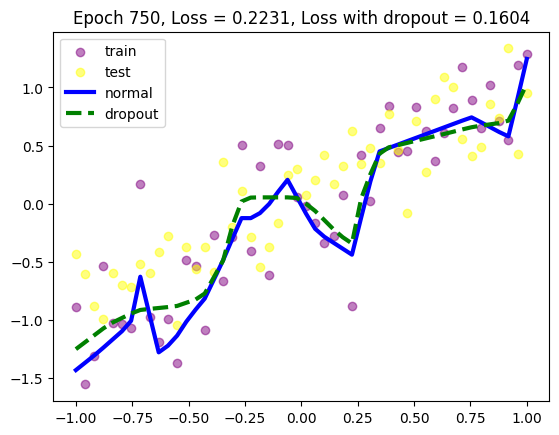

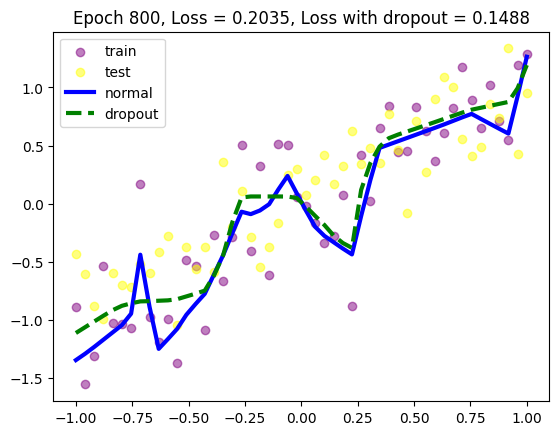

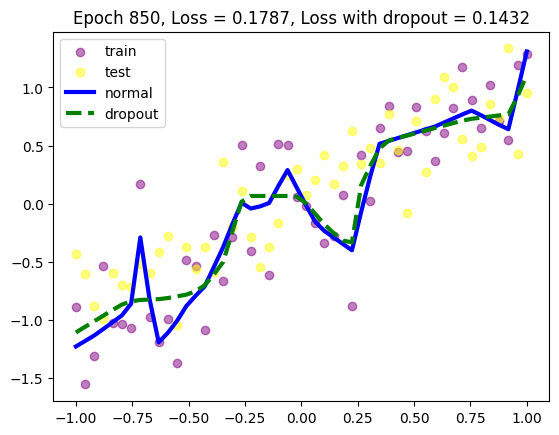

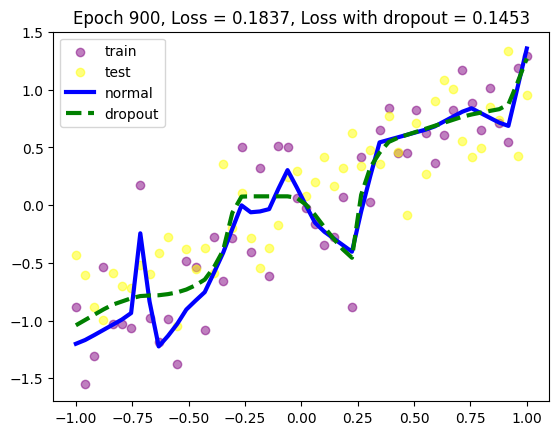

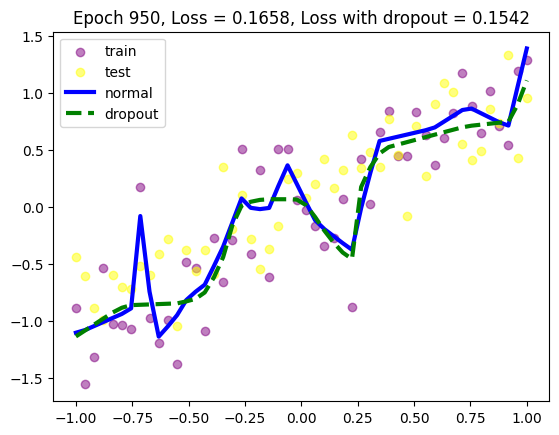

In [ ]:
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train) # 드롭아웃이 적용되지 않은 모델 학습
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(x_train) # 드롭아웃이 적용된 모델 학습
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0: # 50번의 에포크마다 실행
        model.eval() # 모델을 평가 모드로 설정
        model_dropout.eval() # 드롭아웃이 적용된 모델을 평가 모드로 설정

        # 테스트 데이터에 대한 예측값 계산
        test_pred = model(x_test)
        # 테스트 데이터에 대한 손실 계산
        test_loss = loss_fn(test_pred, y_test)

        # 드롭아웃이 적용된 모델을 사용하여 테스트 데이터에 대한 예측값 계산
        test_pred_dropout = model_dropout(x_test)
        # 드롭아웃이 적용된 모델에 대한 테스트 데이터의 손실 계산
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        # 훈련 데이터와 테스트 데이터를 산점도로 그리기
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')

        # 모델과 드롭아웃이 적용된 모델의 예측값을 그래프로 그리기
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')

        # 그래프에 제목과 범례 추가
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()

        model.train() # 모델을 훈련 모드로 설정
        model_dropout.train() # 드롭아웃이 적용된 모델을 훈련 모드로 설정
        plt.pause(0.05) # 그래프가 화면에 표시된 후 0.05초 동안 멈춤

# 8.3.3 조기 종료

### 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models # 사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot') # 출력 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 스타일

### GPU 사용

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 데이터셋 전처리

In [3]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

### 데이터셋 업로드

In [4]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [5]:
!mkdir archive

In [6]:
!unzip archive.zip -d ./archive

Archive:  archive.zip
   creating: ./archive/test/
   creating: ./archive/test/hot_dog/
  inflating: ./archive/test/hot_dog/133012.jpg  
  inflating: ./archive/test/hot_dog/133015.jpg  
  inflating: ./archive/test/hot_dog/133245.jpg  
  inflating: ./archive/test/hot_dog/135628.jpg  
  inflating: ./archive/test/hot_dog/138933.jpg  
  inflating: ./archive/test/hot_dog/138937.jpg  
  inflating: ./archive/test/hot_dog/138969.jpg  
  inflating: ./archive/test/hot_dog/139177.jpg  
  inflating: ./archive/test/hot_dog/142835.jpg  
  inflating: ./archive/test/hot_dog/143012.jpg  
  inflating: ./archive/test/hot_dog/144956.jpg  
  inflating: ./archive/test/hot_dog/146227.jpg  
  inflating: ./archive/test/hot_dog/146834.jpg  
  inflating: ./archive/test/hot_dog/147874.jpg  
  inflating: ./archive/test/hot_dog/152106.jpg  
  inflating: ./archive/test/hot_dog/154409.jpg  
  inflating: ./archive/test/hot_dog/154545.jpg  
  inflating: ./archive/test/hot_dog/156126.jpg  
  inflating: ./archive/test/ho

### 데이터셋 가져오기 (핫도그와 핫도그가 아닌 이미지들)

In [7]:
train_dataset = datasets.ImageFolder(
    root=r'./archive/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, # 데이터셋을 배치 크기로 메모리로 가져온다
                                                # 일반적인 PC 메모리 용량(16~24GB)을 고려하여 한 번에 32개의 이미지를 불러오도록 설정한다
)
val_dataset = datasets.ImageFolder(
    root=r'./archive/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

### 모델 생성 (사전 학습된 ResNet50 사용)

In [8]:
def resnet50(pretrained=True):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False: # 파라미터를 고정하여 backward() 중에 기울기가 계산되지 않도록 한다
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True: # 파라미터 값이 backward() 중에 기울기 계산에 반영된다
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2) # 마지막 분류를 위한 계층은 학습을 진행한다
    return model

### 학습률 감소

In [9]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        # optimizer: 사용할 optimizer
        # patience: 성능이 개선되지 않은 상태를 얼마나 기다릴지 결정하는 변수
        # min_lr: 최소 학습률
        # factor: 학습률을 감소시킬 비율
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        # ReduceLROnPlateau 스케줄러 초기화
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',  # 성능 지표를 최소화하려고 함
                patience=self.patience,  # patience 값 설정
                factor=self.factor,  # 학습률을 감소시킬 비율 설정
                min_lr=self.min_lr,  # 학습률의 최소값 설정
                verbose=True  # 감소된 학습률 출력 여부
            )
    def __call__(self, val_loss):
        # 검증 손실을 입력으로 받아 학습률 조절
        self.lr_scheduler.step(val_loss) # 실제로 학습률을 업데이트한다
                                         # epoch 단위로 검증 데이터셋에 대한 오차를 받아 이전 오차와 비교했을 때 차이가 없다면 학습률을 업데이트한다

In [10]:
uploaded = files.upload()

Saving checkpoint.pt to checkpoint.pt


### 조기 종료
- 특정 epoch 후에도 오차가 개선되지 않을 때 훈련을 조기 종료한다.

In [11]:
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='./checkpoint.pt'):
        # 오차가 개선되지 않은 epoch를 기다리는 횟수
        self.patience = patience
        # 조기 종료의 시작과 끝을 출력하는지 여부
        self.verbose = verbose
        # 오차가 개선되었다고 판단하기 위한 최소 변화
        self.delta = delta
        # 모델의 상태를 저장할 경로
        self.path = path
        # 오차가 개선되지 않은 횟수를 카운트
        self.counter = 0
        # 가장 낮은 검증 오차
        self.best_score = None
        # 조기 종료 여부
        self.early_stop = False

    # 검증 오차를 받아 모델을 저장하고, 조기 종료 여부를 판단한다.
    def __call__(self, val_loss, model):
        # 현재 검증 오차의 점수
        score = -val_loss

        # 최초 검증 오차인 경우
        if self.best_score is None:
            self.best_score = score
            # 모델 저장
            self.save_checkpoint(val_loss, model)
        # 검증 오차가 최고 점수보다 높은 경우
        elif score < self.best_score + self.delta:
            self.counter += 1
            # 조기 종료 카운터 증가
            print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            # 오차가 개선되지 않은 횟수가 설정한 허용값과 같아진 경우
            if self.counter >= self.patience:
                # 조기 종료
                self.early_stop = True
        # 검증 오차가 개선되었을 경우
        else:
            # 최고 점수 갱신
            self.best_score = score
            # 모델 저장
            self.save_checkpoint(val_loss, model)
            # 조기 종료 카운터 초기화
            self.counter = 0

    # 모델을 저장하는 함수
    def save_checkpoint(self, val_loss, model):
        # 설정한 verbose가 True일 경우 메시지 출력
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # 모델 저장
        torch.save(model.state_dict(), self.path)
        # 최저 검증 오차 업데이트
        self.val_loss_min = val_loss

### 인수 값 지정
- 함수에 넘겨주는 인수(argument) 값에 따라 다른 동작을 하도록 한다.
- 이때 사용할 수 있는 것이 argparse 라이브러리이다.

In [12]:
parser = argparse.ArgumentParser() # 인수 값을 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true') # 옵션 문자열의 이름, 입력 값이 저장되는 변수, 입력 값을 생성된 변수에 저장
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true') # 조기 종료에 대한 인수
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다
args = vars(parser.parse_args()) # 입력받은 인수 값이 실제로 args 변수에 저장된다

### 사전 훈련된 모델(ResNet50)의 파라미터 확인

In [13]:
#!pip install ipywidgets 혹은
#anaconda prompt에서 conda install -c conda-forge ipywidgets 실행

print(f"Computation device: {device}\n") # CPU 사용 / GPU 사용하는지 검사
model = models.resnet50(pretrained=True).to(device) # 사전 훈련된 ResNet50 사용
total_params = sum(p.numel() for p in model.parameters()) # 총 파라미터 수
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad) # 학습 가능한 파라미터 수
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.2MB/s]


25,557,032 total parameters.
25,557,032 training parameters.


### 옵티마이저와 손실 함수 지정

In [14]:
lr = 0.001 # 초기 학습률
epochs = 100 # 에포크
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

### 오차, 정확도 및 모델의 이름에 대한 문자열 (어떤 인수도 사용하지 않을 때)

In [15]:
loss_plot_name = 'loss' # 오차 출력에 대한 문자열
acc_plot_name = 'accuracy' # 정확도 출력에 대한 문자열
model_name = 'model' # 모델을 저장하기 위한 문자열

### 오차, 정확도 및 모델의 이름에 대한 문자열 ('--lr-scheduler' 또는 '--early-stopping'인수를 사용할 경우)

In [16]:
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss' # 학습률 감소를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'lrs_accuracy' # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
    model_name = 'lrs_model' # 학습률 감소를 적용했을 때의 모델에 대한 문자열
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss' # 조기 종료를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'es_accuracy' # 조기 종료를 적용했을 때의 정확도에 대한 문자열
    model_name = 'es_model' # 조기 종료를 적용했을 때의 모델에 대한 문자열

### 모델 학습 함수

In [17]:
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training') # 훈련 시작 메시지 출력
    model.train() # 모델을 훈련 모드로 설정
    train_running_loss = 0.0 # 훈련 손실 초기화
    train_running_correct = 0 # 정확하게 예측한 샘플 수 초기화
    counter = 0 # 반복 횟수 초기화
    total = 0 # 전체 샘플 수 초기화
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    # tqdm을 사용하여 진행 상황을 출력하고, 배치 수에 맞게 전체 진행도를 조절
    for i, data in prog_bar:
        counter += 1 # 반복 횟수 증가
        data, target = data[0].to(device), data[1].to(device) # 데이터와 레이블을 GPU로 전송
        total += target.size(0) # 전체 샘플 수 업데이트
        optimizer.zero_grad() # 그레이디언트 초기화
        outputs = model(data) # 모델 예측
        loss = criterion(outputs, target) # 손실 계산
        train_running_loss += loss.item() # 훈련 손실 업데이트
        _, preds = torch.max(outputs.data, 1) # 예측된 클래스 결정
        train_running_correct += (preds == target).sum().item() # 정확하게 예측한 샘플 수 업데이트
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 업데이트

    train_loss = train_running_loss / counter # 훈련 손실 계산
    train_accuracy = 100. * train_running_correct / total # 훈련 정확도 계산
    return train_loss, train_accuracy # 훈련 손실과 정확도 반환

### 모델 검증 함수

In [18]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating') # 검증 시작 메시지 출력
    model.eval() # 모델을 평가 모드로 설정
    val_running_loss = 0.0 # 검증 손실 초기화
    val_running_correct = 0 # 정확하게 예측한 샘플 수 초기화
    counter = 0 # 반복 횟수 초기화
    total = 0 # 전체 샘플 수 초기화
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    # tqdm을 사용하여 진행 상황을 출력하고, 배치 수에 맞게 전체 진행도를 조절
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for i, data in prog_bar:
            counter += 1 # 반복 횟수 증가
            data, target = data[0].to(device), data[1].to(device) # 데이터와 레이블을 GPU로 전송
            total += target.size(0) # 전체 샘플 수 업데이트
            outputs = model(data) # 모델 예측
            loss = criterion(outputs, target) # 손실 계산

            val_running_loss += loss.item() # 검증 손실 업데이트
            _, preds = torch.max(outputs.data, 1) # 예측된 클래스 결정
            val_running_correct += (preds == target).sum().item() # 정확하게 예측한 샘플 수 업데이트

        val_loss = val_running_loss / counter # 검증 손실 계산
        val_accuracy = 100. * val_running_correct / total # 검증 정확도 계산
        return val_loss, val_accuracy # 검증 손실과 정확도 반환

### 모델 학습

In [19]:
train_loss, train_accuracy = [], [] # 훈련 손실과 정확도를 저장할 리스트 초기화
val_loss, val_accuracy = [], [] # 검증 손실과 정확도를 저장할 리스트 초기화

start = time.time() # 훈련 시작 시간 기록
for epoch in range(epochs): # 주어진 epoch 수 만큼 반복
    print(f"Epoch {epoch+1} of {epochs}") # 현재 epoch 번호 출력
    # 훈련 및 검증 실행
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    # 훈련 및 검증 손실과 정확도 기록
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    # 학습률 스케줄러 실행 (인수 값이 lr_scheduler이면 다음을 실행)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    # 조기 종료 실행 (인수 값이 early_stopping이면 다음을 실행)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        # 조기 종료가 발생한 경우 훈련 종료
        if early_stopping.early_stop:
            break
    # 현재 epoch의 손실과 정확도 출력
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time() # 훈련 종료 시간 기록
print(f"Training time: {(end-start)/60:.3f} minutes") # 훈련 시간 출력

Epoch 1 of 100
Training


16it [00:06,  2.46it/s]


Validating


16it [00:03,  4.74it/s]


Train Loss: 2.1347, Train Acc: 60.44
Val Loss: 186.3136, Val Acc: 46.00
Epoch 2 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:03,  4.29it/s]


Train Loss: 0.6133, Train Acc: 69.88
Val Loss: 0.9973, Val Acc: 63.80
Epoch 3 of 100
Training


16it [00:04,  3.51it/s]


Validating


16it [00:04,  3.97it/s]


Train Loss: 0.5151, Train Acc: 76.31
Val Loss: 0.6733, Val Acc: 69.60
Epoch 4 of 100
Training


16it [00:04,  3.24it/s]


Validating


16it [00:03,  4.81it/s]


Train Loss: 0.4849, Train Acc: 78.11
Val Loss: 1.7397, Val Acc: 58.40
Epoch 5 of 100
Training


16it [00:05,  2.79it/s]


Validating


16it [00:04,  3.61it/s]


Train Loss: 0.4485, Train Acc: 80.12
Val Loss: 0.7394, Val Acc: 71.60
Epoch 6 of 100
Training


16it [00:04,  3.48it/s]


Validating


16it [00:03,  4.08it/s]


Train Loss: 0.3363, Train Acc: 85.54
Val Loss: 0.6730, Val Acc: 71.20
Epoch 7 of 100
Training


16it [00:04,  3.32it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.2250, Train Acc: 92.57
Val Loss: 2.1472, Val Acc: 57.00
Epoch 8 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.30it/s]


Train Loss: 0.3193, Train Acc: 85.54
Val Loss: 0.6145, Val Acc: 71.80
Epoch 9 of 100
Training


16it [00:04,  3.39it/s]


Validating


16it [00:04,  3.95it/s]


Train Loss: 0.3124, Train Acc: 86.75
Val Loss: 0.7607, Val Acc: 75.80
Epoch 10 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.33it/s]


Train Loss: 0.2439, Train Acc: 90.76
Val Loss: 0.7359, Val Acc: 72.20
Epoch 11 of 100
Training


16it [00:04,  3.24it/s]


Validating


16it [00:04,  3.65it/s]


Train Loss: 0.2197, Train Acc: 91.37
Val Loss: 0.6536, Val Acc: 81.00
Epoch 12 of 100
Training


16it [00:04,  3.39it/s]


Validating


16it [00:04,  3.85it/s]


Train Loss: 0.2526, Train Acc: 90.36
Val Loss: 0.7611, Val Acc: 73.00
Epoch 13 of 100
Training


16it [00:04,  3.38it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.2149, Train Acc: 91.77
Val Loss: 0.9830, Val Acc: 72.60
Epoch 14 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.2039, Train Acc: 93.57
Val Loss: 0.6232, Val Acc: 75.80
Epoch 15 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:04,  3.98it/s]


Train Loss: 0.1614, Train Acc: 93.37
Val Loss: 0.5778, Val Acc: 76.80
Epoch 16 of 100
Training


16it [00:04,  3.32it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.1433, Train Acc: 94.18
Val Loss: 1.5504, Val Acc: 65.60
Epoch 17 of 100
Training


16it [00:04,  3.24it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.1179, Train Acc: 95.38
Val Loss: 0.5446, Val Acc: 81.60
Epoch 18 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.12it/s]


Train Loss: 0.1257, Train Acc: 96.18
Val Loss: 0.6881, Val Acc: 76.20
Epoch 19 of 100
Training


16it [00:04,  3.20it/s]


Validating


16it [00:03,  4.50it/s]


Train Loss: 0.1390, Train Acc: 94.18
Val Loss: 0.6709, Val Acc: 76.40
Epoch 20 of 100
Training


16it [00:05,  3.07it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.1784, Train Acc: 92.97
Val Loss: 0.8644, Val Acc: 80.20
Epoch 21 of 100
Training


16it [00:05,  3.08it/s]


Validating


16it [00:03,  4.45it/s]


Train Loss: 0.1641, Train Acc: 93.17
Val Loss: 0.7257, Val Acc: 75.20
Epoch 22 of 100
Training


16it [00:05,  2.85it/s]


Validating


16it [00:05,  2.96it/s]


Train Loss: 0.1487, Train Acc: 94.78
Val Loss: 1.0521, Val Acc: 70.20
Epoch 23 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.1518, Train Acc: 94.38
Val Loss: 0.6385, Val Acc: 74.80
Epoch 24 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.1330, Train Acc: 94.58
Val Loss: 1.3657, Val Acc: 69.80
Epoch 25 of 100
Training


16it [00:04,  3.21it/s]


Validating


16it [00:03,  4.17it/s]


Train Loss: 0.1479, Train Acc: 95.58
Val Loss: 0.8077, Val Acc: 79.40
Epoch 26 of 100
Training


16it [00:04,  3.23it/s]


Validating


16it [00:03,  4.34it/s]


Train Loss: 0.2476, Train Acc: 91.16
Val Loss: 1.1460, Val Acc: 68.40
Epoch 27 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.1513, Train Acc: 94.58
Val Loss: 0.7462, Val Acc: 70.80
Epoch 28 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.57it/s]


Train Loss: 0.0979, Train Acc: 95.78
Val Loss: 0.5862, Val Acc: 78.60
Epoch 29 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.04it/s]


Train Loss: 0.0829, Train Acc: 96.79
Val Loss: 0.7111, Val Acc: 76.80
Epoch 30 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.0718, Train Acc: 97.99
Val Loss: 0.8243, Val Acc: 74.80
Epoch 31 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0717, Train Acc: 97.59
Val Loss: 0.5866, Val Acc: 79.40
Epoch 32 of 100
Training


16it [00:05,  2.92it/s]


Validating


16it [00:04,  3.97it/s]


Train Loss: 0.0863, Train Acc: 97.19
Val Loss: 0.8092, Val Acc: 78.20
Epoch 33 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.0932, Train Acc: 96.59
Val Loss: 1.0497, Val Acc: 70.00
Epoch 34 of 100
Training


16it [00:05,  3.09it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0836, Train Acc: 96.99
Val Loss: 0.7068, Val Acc: 81.40
Epoch 35 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.31it/s]


Train Loss: 0.1083, Train Acc: 96.39
Val Loss: 0.8394, Val Acc: 75.40
Epoch 36 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.21it/s]


Train Loss: 0.1625, Train Acc: 93.17
Val Loss: 1.8487, Val Acc: 65.40
Epoch 37 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.2564, Train Acc: 91.97
Val Loss: 0.9183, Val Acc: 70.80
Epoch 38 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.2097, Train Acc: 90.96
Val Loss: 0.6442, Val Acc: 75.00
Epoch 39 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.04it/s]


Train Loss: 0.1660, Train Acc: 94.38
Val Loss: 0.5952, Val Acc: 77.40
Epoch 40 of 100
Training


16it [00:05,  3.20it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.1937, Train Acc: 92.77
Val Loss: 0.7343, Val Acc: 73.20
Epoch 41 of 100
Training


16it [00:05,  3.09it/s]


Validating


16it [00:03,  4.42it/s]


Train Loss: 0.0746, Train Acc: 98.39
Val Loss: 0.7110, Val Acc: 78.00
Epoch 42 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0624, Train Acc: 98.39
Val Loss: 0.6931, Val Acc: 80.80
Epoch 43 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.45it/s]


Train Loss: 0.0223, Train Acc: 99.80
Val Loss: 0.7510, Val Acc: 78.80
Epoch 44 of 100
Training


16it [00:05,  2.91it/s]


Validating


16it [00:03,  4.60it/s]


Train Loss: 0.0241, Train Acc: 99.20
Val Loss: 0.7417, Val Acc: 79.20
Epoch 45 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.10it/s]


Train Loss: 0.0052, Train Acc: 100.00
Val Loss: 0.7436, Val Acc: 79.80
Epoch 46 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.52it/s]


Train Loss: 0.0118, Train Acc: 99.80
Val Loss: 0.8490, Val Acc: 80.00
Epoch 47 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.58it/s]


Train Loss: 0.0203, Train Acc: 99.40
Val Loss: 0.8739, Val Acc: 77.40
Epoch 48 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.47it/s]


Train Loss: 0.0140, Train Acc: 99.60
Val Loss: 0.8500, Val Acc: 78.20
Epoch 49 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.20it/s]


Train Loss: 0.0640, Train Acc: 97.79
Val Loss: 1.2618, Val Acc: 72.00
Epoch 50 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.1116, Train Acc: 95.78
Val Loss: 1.4359, Val Acc: 74.40
Epoch 51 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.2152, Train Acc: 91.37
Val Loss: 0.8898, Val Acc: 74.20
Epoch 52 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.03it/s]


Train Loss: 0.2219, Train Acc: 91.57
Val Loss: 2.1470, Val Acc: 61.40
Epoch 53 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.3387, Train Acc: 87.55
Val Loss: 1.7723, Val Acc: 61.80
Epoch 54 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.3321, Train Acc: 88.35
Val Loss: 1.5059, Val Acc: 64.00
Epoch 55 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.06it/s]


Train Loss: 0.1679, Train Acc: 93.78
Val Loss: 0.7178, Val Acc: 76.40
Epoch 56 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.49it/s]


Train Loss: 0.0833, Train Acc: 96.79
Val Loss: 0.8740, Val Acc: 73.20
Epoch 57 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0637, Train Acc: 97.59
Val Loss: 0.6928, Val Acc: 81.40
Epoch 58 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.42it/s]


Train Loss: 0.0533, Train Acc: 98.59
Val Loss: 0.6094, Val Acc: 81.80
Epoch 59 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.11it/s]


Train Loss: 0.0570, Train Acc: 97.39
Val Loss: 0.6946, Val Acc: 80.80
Epoch 60 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.0633, Train Acc: 98.39
Val Loss: 0.9863, Val Acc: 76.00
Epoch 61 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.0563, Train Acc: 97.59
Val Loss: 0.9333, Val Acc: 76.00
Epoch 62 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0517, Train Acc: 97.79
Val Loss: 0.8806, Val Acc: 75.60
Epoch 63 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.57it/s]


Train Loss: 0.0792, Train Acc: 96.99
Val Loss: 0.8980, Val Acc: 76.00
Epoch 64 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0333, Train Acc: 99.00
Val Loss: 0.7761, Val Acc: 79.60
Epoch 65 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.10it/s]


Train Loss: 0.0184, Train Acc: 99.60
Val Loss: 0.7186, Val Acc: 80.00
Epoch 66 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.41it/s]


Train Loss: 0.0192, Train Acc: 99.20
Val Loss: 0.6491, Val Acc: 83.80
Epoch 67 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.0425, Train Acc: 98.59
Val Loss: 0.7806, Val Acc: 81.00
Epoch 68 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.45it/s]


Train Loss: 0.0234, Train Acc: 99.00
Val Loss: 0.9514, Val Acc: 78.20
Epoch 69 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.02it/s]


Train Loss: 0.0234, Train Acc: 99.40
Val Loss: 0.9023, Val Acc: 75.60
Epoch 70 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.0247, Train Acc: 98.59
Val Loss: 0.8773, Val Acc: 80.00
Epoch 71 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0328, Train Acc: 99.00
Val Loss: 1.0289, Val Acc: 77.40
Epoch 72 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0624, Train Acc: 97.79
Val Loss: 1.0376, Val Acc: 74.80
Epoch 73 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.0701, Train Acc: 96.99
Val Loss: 1.4355, Val Acc: 69.60
Epoch 74 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.1045, Train Acc: 96.18
Val Loss: 1.2823, Val Acc: 71.00
Epoch 75 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.27it/s]


Train Loss: 0.1267, Train Acc: 95.98
Val Loss: 2.1357, Val Acc: 65.80
Epoch 76 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.32it/s]


Train Loss: 0.1617, Train Acc: 94.18
Val Loss: 0.9486, Val Acc: 75.80
Epoch 77 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:03,  4.07it/s]


Train Loss: 0.1164, Train Acc: 94.78
Val Loss: 0.9416, Val Acc: 74.40
Epoch 78 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.1096, Train Acc: 96.18
Val Loss: 0.9116, Val Acc: 76.20
Epoch 79 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.05it/s]


Train Loss: 0.0683, Train Acc: 96.99
Val Loss: 0.5738, Val Acc: 79.00
Epoch 80 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.0515, Train Acc: 98.19
Val Loss: 0.5993, Val Acc: 80.00
Epoch 81 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.13it/s]


Train Loss: 0.0595, Train Acc: 97.79
Val Loss: 0.7220, Val Acc: 80.00
Epoch 82 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.07it/s]


Train Loss: 0.0303, Train Acc: 99.40
Val Loss: 0.9886, Val Acc: 74.60
Epoch 83 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.49it/s]


Train Loss: 0.0243, Train Acc: 99.20
Val Loss: 0.8262, Val Acc: 76.80
Epoch 84 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.0560, Train Acc: 97.79
Val Loss: 0.9897, Val Acc: 75.40
Epoch 85 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.51it/s]


Train Loss: 0.0254, Train Acc: 99.20
Val Loss: 1.0134, Val Acc: 76.20
Epoch 86 of 100
Training


16it [00:05,  3.20it/s]


Validating


16it [00:03,  4.18it/s]


Train Loss: 0.0160, Train Acc: 99.40
Val Loss: 0.6807, Val Acc: 81.00
Epoch 87 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.0146, Train Acc: 99.60
Val Loss: 0.8348, Val Acc: 78.40
Epoch 88 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.0188, Train Acc: 99.40
Val Loss: 0.8999, Val Acc: 77.00
Epoch 89 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:04,  3.99it/s]


Train Loss: 0.0289, Train Acc: 98.80
Val Loss: 0.8393, Val Acc: 80.00
Epoch 90 of 100
Training


16it [00:05,  3.19it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.0587, Train Acc: 98.19
Val Loss: 1.0429, Val Acc: 75.60
Epoch 91 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.0680, Train Acc: 97.59
Val Loss: 0.8977, Val Acc: 76.20
Epoch 92 of 100
Training


16it [00:05,  3.17it/s]


Validating


16it [00:03,  4.13it/s]


Train Loss: 0.0295, Train Acc: 99.20
Val Loss: 1.2667, Val Acc: 70.60
Epoch 93 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.37it/s]


Train Loss: 0.0321, Train Acc: 98.80
Val Loss: 1.1078, Val Acc: 73.40
Epoch 94 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0446, Train Acc: 98.19
Val Loss: 1.0478, Val Acc: 75.00
Epoch 95 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:03,  4.51it/s]


Train Loss: 0.0742, Train Acc: 97.59
Val Loss: 1.0200, Val Acc: 77.80
Epoch 96 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.06it/s]


Train Loss: 0.0472, Train Acc: 98.19
Val Loss: 1.0322, Val Acc: 79.40
Epoch 97 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.0879, Train Acc: 97.39
Val Loss: 1.3087, Val Acc: 74.20
Epoch 98 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:03,  4.60it/s]


Train Loss: 0.0633, Train Acc: 97.19
Val Loss: 1.4820, Val Acc: 68.20
Epoch 99 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.00it/s]


Train Loss: 0.0673, Train Acc: 96.79
Val Loss: 1.5479, Val Acc: 69.40
Epoch 100 of 100
Training


16it [00:05,  3.18it/s]


Validating


16it [00:03,  4.66it/s]

Train Loss: 0.0867, Train Acc: 96.79
Val Loss: 0.8414, Val Acc: 81.00
Training time: 14.579 minutes


### 모델 학습 결과 출력

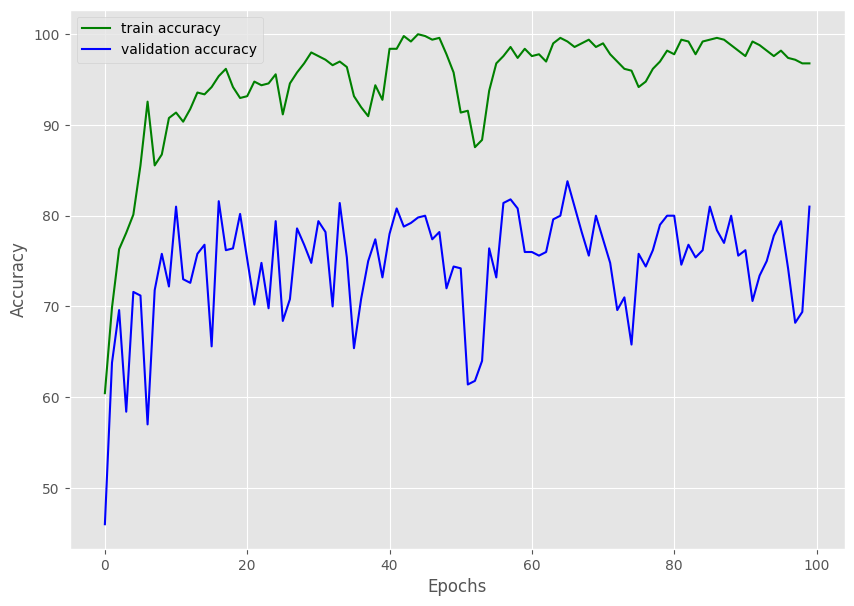

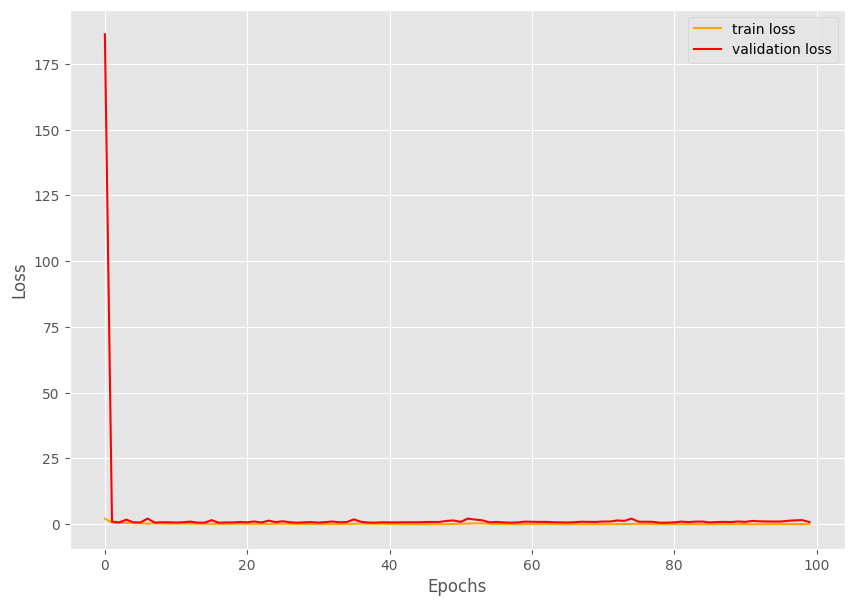

Saving model...
TRAINING COMPLETE


In [20]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy') # 훈련 정확도 그래프
plt.plot(val_accuracy, color='blue', label='validation accuracy') # 검증 정확도 그래프
plt.xlabel('Epochs') # x축 레이블
plt.ylabel('Accuracy') # y축 레이블
plt.legend() # 범례 표시
plt.savefig(f"./archive/img/{acc_plot_name}.png") # 그래프 이미지 저장
plt.show() # 그래프 출력

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss') # 훈련 손실 그래프
plt.plot(val_loss, color='red', label='validation loss') # 검증 손실 그래프
plt.xlabel('Epochs') # x축 레이블
plt.ylabel('Loss') # y축 레이블
plt.legend() # 범례 표시
plt.savefig(f"./archive/img/{loss_plot_name}.png") # 그래프 이미지 저장
plt.show() # 그래프 출력

print('Saving model...') # 모델 저장 메시지 출력
torch.save(model.state_dict(), f"./archive/{model_name}.pth") # 모델 저장
print('TRAINING COMPLETE') # 훈련 완료 메시지 출력